In [1]:
import os
import torch
import pandas as pd
import numpy as np

from tqdm import tqdm
from PIL import Image
from PIL import Image, ImageDraw
from torchvision import tv_tensors
from matplotlib import pyplot as plt
from torchvision import transforms, models
from datumaro.components.dataset import Dataset
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from Instance_Segmentation.image_from_mask import extract_object_by_mask
from Instance_Segmentation.test_model import SampleDataset
from Instance_Segmentation.train_model import get_model_instance_segmentation
from Instance_Segmentation import utils
from Instance_Segmentation.engine import evaluate
from inference import get_feature_extractor, get_class, get_classificaion_params


##Segmentation model

In [2]:
test_root = r'Data/CVAT_dataset'
model_root = r'Save/models/InSegModel_fb'

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

model = get_model_instance_segmentation(num_classes=2, pre_trained=False)
model.load_state_dict(torch.load(model_root, map_location=device))
model.to(device)
model.eval()
dataset_test = SampleDataset(root=test_root)

data_loader_test = torch.utils.data.DataLoader(
dataset_test,
batch_size=6,
shuffle=False,
collate_fn=utils.collate_fn,
)    

evaluate(model, data_loader_test, device)

creating index...
index created!


/opt/conda/lib/python3.11/site-packages/torch/nn/modules/conv.py:456: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,


Test:  [  0/104]  eta: 0:07:46  model_time: 4.1565 (4.1565)  evaluator_time: 0.0586 (0.0586)  time: 4.4813  data: 0.2391  max mem: 5203
Test:  [ 50/104]  eta: 0:03:27  model_time: 3.4457 (3.4519)  evaluator_time: 0.0896 (0.1109)  time: 3.8129  data: 0.2444  max mem: 5211
Test:  [100/104]  eta: 0:00:15  model_time: 3.4505 (3.4532)  evaluator_time: 0.0898 (0.1066)  time: 3.8008  data: 0.2378  max mem: 5211
Test:  [103/104]  eta: 0:00:03  model_time: 3.4495 (3.4257)  evaluator_time: 0.0802 (0.1048)  time: 3.6342  data: 0.2224  max mem: 5211
Test: Total time: 0:06:35 (3.8065 s / it)
Averaged stats: model_time: 3.4495 (3.4257)  evaluator_time: 0.0802 (0.1048)
Accumulating evaluation results...
DONE (t=0.04s).
Accumulating evaluation results...
DONE (t=0.04s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.747
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.984
 Average Precision  (AP) @[ IoU=0.75      | area=   all | 

##Classification model

In [3]:
def extract_features(img, feature_extractor):
    preprocess = transforms.Compose(
        [
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
        ]
    )

    img_tensor = preprocess(img).unsqueeze(0)
    with torch.no_grad():
        features = feature_extractor(img_tensor)
    return features.squeeze().numpy()

In [4]:
legend_path = r'Data/legend/Pollen DB Legend.json'
db_path = 'Data/db_folder/Pollen DB Swin Transformer.ann'
input_dir = r'Data/CVAT_dataset/images/Test/Sample_1'

In [5]:
path_to_xml = os.path.join(test_root, 'annotations.xml')
path_to_images = os.path.join(test_root, 'images/Test/Sample_1')
dataset = Dataset.import_from(path=path_to_xml, format='cvat')

score_threshold = 0.9
mask_threshold = 0.75


cl_model = models.swin_t(weights="DEFAULT")
feature_extractor = get_feature_extractor(cl_model)

db, index_to_class, k, labels = get_classificaion_params(legend_path, db_path)

labels += ['Undefined']
df_pred = pd.DataFrame(columns=labels)
df_true = pd.DataFrame(columns=labels)


namespace = {}
image_id = 0

print('Iterating through dataset:')
for item in tqdm(dataset):
    image_name = item.id.split('/')[1] + '.jpg'
    mscp_image = Image.open(os.path.join(path_to_images, image_name))
    for ann in item.annotations:
        if ann.type.name == 'polygon':
            mask = Image.new('L', item.media.size[::-1], 0)
            draw = ImageDraw.Draw(mask)

            polygon_points = ann.points
            draw.polygon(polygon_points, outline=1, fill=1)
            mask_array = np.array(mask)

            prc_img = tv_tensors.Image(mscp_image)
            prc_img = prc_img.cpu().numpy()
            prc_img = np.transpose(prc_img, (1, 2, 0))
            extracted_image = extract_object_by_mask(mask_array, prc_img).convert('RGB')
            vector = extract_features(extracted_image, feature_extractor)

            pred_label = get_class(db, vector, index_to_class, k)
            true_label = ann.attributes.get('Specie')
            
            
            nrow_pred = {col: 0 for col in df_pred.columns}
            nrow_true = {col: 0 for col in df_true.columns}
            nrow_pred[pred_label] = 1
            nrow_true[true_label] = 1    

            df_pred.loc[image_id] = nrow_pred
            df_true.loc[image_id] = nrow_true
            image_id += 1


Iterating through dataset:


100%|██████████| 619/619 [00:56<00:00, 10.99it/s]


In [6]:
df_pred

,Urtica,Populus tremula,Tilia,Poaceae,Salix,Plantago,Acer,Artemisia,Picea,Corylus,Betula,Chenopodiaceae,Fraxinus,Apiaceae,Quercus,Pinus,Alnus,Rumex,Undefined
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
801,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
802,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
803,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
804,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0


In [7]:
true_labels = df_true.values

# Convert predicted labels to class indices
predicted_labels = df_pred.values

# Generate the classification report
report = classification_report(true_labels, predicted_labels, target_names=labels, zero_division=0)
print(report)


                 precision    recall  f1-score   support

         Urtica       0.00      0.00      0.00         0
Populus tremula       0.98      0.48      0.65       335
          Tilia       0.00      0.00      0.00         0
        Poaceae       0.00      0.00      0.00         0
          Salix       0.00      0.00      0.00         3
       Plantago       0.00      0.00      0.00         0
           Acer       0.00      0.00      0.00         0
      Artemisia       0.00      0.00      0.00         0
          Picea       0.00      0.00      0.00         0
        Corylus       1.00      0.01      0.02       123
         Betula       0.09      0.19      0.12        16
 Chenopodiaceae       0.00      0.00      0.00         1
       Fraxinus       0.00      0.00      0.00         0
       Apiaceae       0.00      0.00      0.00         0
        Quercus       0.00      0.00      0.00         0
          Pinus       0.00      0.00      0.00         0
          Alnus       0.71    

{1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18}


Text(0.5, 1.0, 'Confusion Matrix')

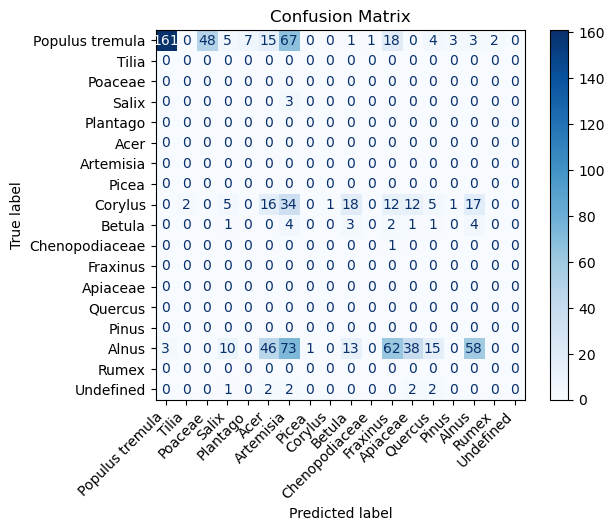

In [8]:
true_labels = df_true.values.argmax(1)

# Convert predicted labels to class indices
predicted_labels = df_pred.values.argmax(1)

label_nums = set.union(set(predicted_labels), set(true_labels))
print(label_nums)

found_labels = []
for num in label_nums:
    found_labels += [labels[num]]


# Generate the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)
# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=found_labels)
disp.plot(cmap=plt.cm.Blues)
plt.xticks(rotation=45, ha='right')
plt.title('Confusion Matrix')